### 整合性

$a_{jk}^\text{L} w_k^\text{U} = w_j^\text{L}, ~ a_{jk}^\text{U} w_k^\text{L} = w_j^\text{U}, ~ j, k \in N, ~ j \neq k$ を満たす解が存在することの必要十分条件は次の通り．

任意の $i \in N$ について次が成り立つ．

$$
a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} = a_{is}^\text{L} a_{sr}^\text{U} a_{ri}^\text{L}, ~~
j \neq k, ~~ s \neq r, ~~ j, k, s, r \in N \backslash \{ i \}
$$

In [1]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [2]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [3]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [4]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [5]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [6]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [7]:
# 対角成分以外の算術平均
function mean(A::Matrix{T})::T where {T <: Real}
    m, n = size(A)

    if m != n return 0 end
    if n == 1 return 0 end

    a = 0
    for i = 1:m, j = 1:n
        if i == j continue end
        a += A[i,j]
    end

    return a / n / (n-1)
end

titles = [
    "行列を結合して二重区間PCMを作り，整合化",
    "整合化しながら結合した重要度を求めて二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"
]

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}, size::Tuple{Integer, Integer}=(1000, 250)) where {T <: Real}
    m = 2 # DM の数

    matrices = [A₁, A₂]
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    p = []; a = []; indmat = []
    for k = 1:length(resultMatrices)
        h = []; indrow = []
        Âₖ⁻, Âₖ⁺ = resultMatrices[k]
        for l = 1:m
            title⁻ = L"S( A_{%$(l)ij}, \hat{A}_{%$(k)ij}^- )"
            title⁺ = L"S( A_{%$(l)ij}, \hat{A}_{%$(k)ij}^+ )"

            heatmap⁻, indices⁻ = plotConincidenceIndices(matrices[l], Âₖ⁻, title⁻)
            heatmap⁺, indices⁺ = plotConincidenceIndices(matrices[l], Âₖ⁺, title⁺)

            push!(h, heatmap⁻); push!(h, heatmap⁺)
            push!(indrow, indices⁻); push!(indrow, indices⁺)
        end

        push!(p, h); push!(a, [Âₖ⁻, Âₖ⁺])
        push!(indmat, indrow)
    end

    for i = eachindex(p)
        display(titles[i])
        A = intervalPCM2TwofoldIntervalPCM(a[i][1], a[i][2])
        display(L"\hat{A}_{%$(i)} = %$(twofoldIntervalMatrixLaTeXString(A))")
        display(plot(p[i]..., layout=(1, 4), size=size, legend=false))
        display("非対角成分の算術平均: $(round(mean(indmat[i][1]), digits=3)), $(round(mean(indmat[i][2]), digits=3)), $(round(mean(indmat[i][3]), digits=3)), $(round(mean(indmat[i][4]), digits=3))")
    end
end

plotAll (generic function with 2 methods)

整合している同じ行列 2 つ

L"$A_1 = A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.0, 2.0 \right] & \left[ 0.667, 1.333 \right] & \left[ 1.0, 1.333 \right] \\ \left[ 0.5, 1.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.444, 1.0 \right] & \left[ 0.667, 1.0 \right] \\ \left[ 0.75, 1.5 \right] & \left[ 1.0, 2.25 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.5 \right] \\ \left[ 0.75, 1.0 \right] & \left[ 1.0, 1.5 \right] & \left[ 0.667, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

true

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[ 1.333, 1.333 \\right],   2.0 \\right] & \\left[ 0.667, \\left[ 0.889, 0.889 \\right], 1.333 \\right] & \\left[   1.0, \\left[ 1.333, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,  0.75 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.5 \\right] & \\left[ 0.667, \\left[ 0.667, 0.667 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

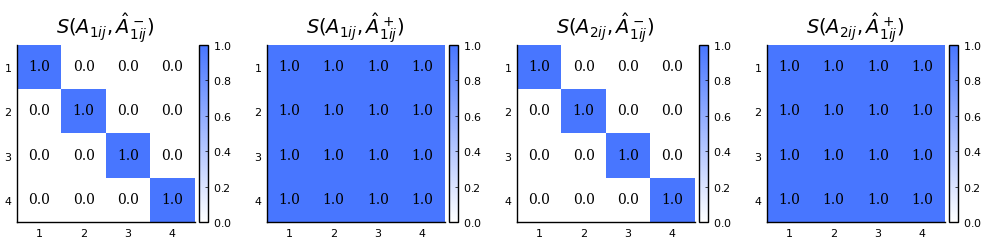

"非対角成分の算術平均: 0.0, 1.0, 0.0, 1.0"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   2.0 \\right],   2.0 \\right] & \\left[ 0.667, \\left[ 0.667, 1.333 \\right], 1.333 \\right] & \\left[   1.0, \\left[   1.0, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.5 \\right],   1.5 \\right] & \\left[ 0.667, \\left[ 0.667,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

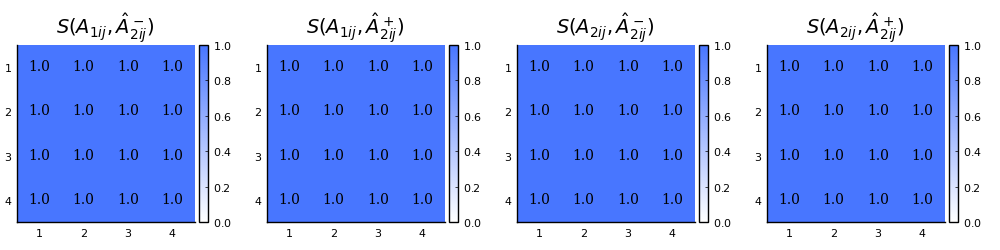

"非対角成分の算術平均: 1.0, 1.0, 1.0, 1.0"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.5, \\left[ 1.778,   2.0 \\right],   2.0 \\right] & \\left[   0.8, \\left[ 0.889, 1.067 \\right], 1.067 \\right] & \\left[   1.0, \\left[ 1.333, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,  0.75 \\right],   1.0 \\right] & \\left[ 1.333, \\left[   1.5,   1.5 \\right],   1.5 \\right] & \\left[ 0.667, \\left[   0.8,   0.8 \\right],   0.8 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

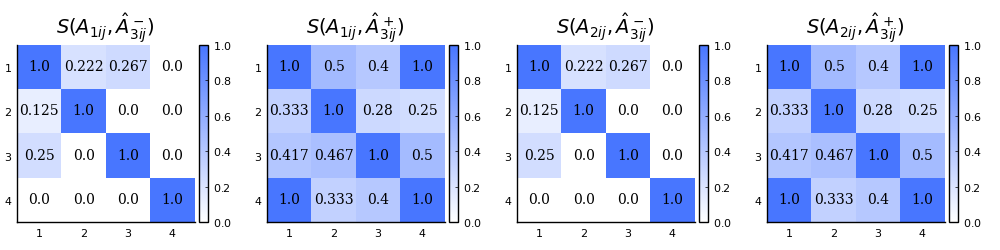

"非対角成分の算術平均: 0.072, 0.49, 0.072, 0.49"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   1.0, \\left[   2.0,   2.0 \\right],   2.0 \\right] & \\left[ 0.667, \\left[ 1.067, 1.067 \\right], 1.333 \\right] & \\left[   1.0, \\left[ 1.333, 1.333 \\right], 1.333 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],   1.5 \\right] \\\\ \\left[  0.75, \\left[  0.75,  0.75 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.5,   1.5 \\right],   1.5 \\right] & \\left[ 0.667, \\left[   0.8,   0.8 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

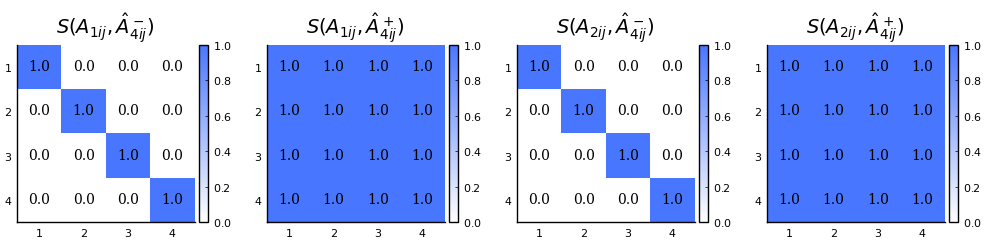

"非対角成分の算術平均: 0.0, 1.0, 0.0, 1.0"

In [15]:
A₁ = [
    1..1 1..2 (2/3)..(4/3) 1..(4/3)
    (1/2)..1 1..1 (4/9)..1 (2/3)..1
    (3/4)..(3/2) 1..(9/4) 1..1 1..(3/2)
    (3/4)..1 1..(3/2) (2/3)..1 1..1
]
A₂ = A₁

display(L"A_1 = A_2 = %$(intervalMatrixLaTeXString(A₁))")

display(isConsistentIntervalPCM(A₁))

plotAll(A₁, A₂)

ともに整合していて， $A_{1ij} \subseteq A_{2ij}$

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.0, 2.0 \right] & \left[ 0.667, 1.333 \right] & \left[ 1.0, 1.333 \right] \\ \left[ 0.5, 1.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.444, 1.0 \right] & \left[ 0.667, 1.0 \right] \\ \left[ 0.75, 1.5 \right] & \left[ 1.0, 2.25 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.5 \right] \\ \left[ 0.75, 1.0 \right] & \left[ 1.0, 1.5 \right] & \left[ 0.667, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 0.8, 2.5 \right] & \left[ 0.533, 1.667 \right] & \left[ 0.8, 1.667 \right] \\ \left[ 0.4, 1.25 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.356, 1.25 \right] & \left[ 0.533, 1.25 \right] \\ \left[ 0.6, 1.875 \right] & \left[ 0.8, 2.812 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.8, 1.875 \right] \\ \left[ 0.6, 1.25 \right] & \left[ 0.8, 1.875 \right] & \left[ 0.533, 1.25 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

true

true

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.8, \\left[ 1.333, 1.333 \\right],   2.5 \\right] & \\left[ 0.533, \\left[ 0.889, 0.889 \\right], 1.667 \\right] & \\left[   0.8, \\left[ 1.333, 1.333 \\right], 1.667 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.875 \\right] \\\\ \\left[   0.6, \\left[  0.75,  0.75 \\right],  1.25 \\right] & \\left[   0.8, \\left[   1.0,   1.0 \\right], 1.875 \\right] & \\left[ 0.533, \\left[ 0.667, 0.667 \\right],  1.25 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

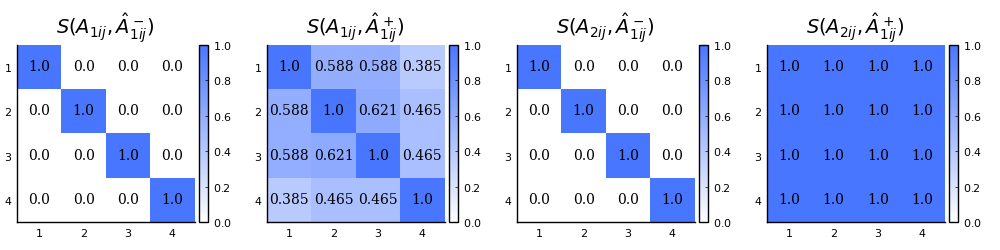

"非対角成分の算術平均: 0.0, 0.519, 0.0, 1.0"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.8, \\left[   1.0,   2.0 \\right],   2.5 \\right] & \\left[ 0.533, \\left[ 0.667, 1.333 \\right], 1.667 \\right] & \\left[   0.8, \\left[   1.0, 1.333 \\right], 1.667 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.875 \\right] \\\\ \\left[   0.6, \\left[  0.75,   1.0 \\right],  1.25 \\right] & \\left[   0.8, \\left[   1.0,   1.5 \\right], 1.875 \\right] & \\left[ 0.533, \\left[ 0.667,   1.0 \\right],  1.25 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

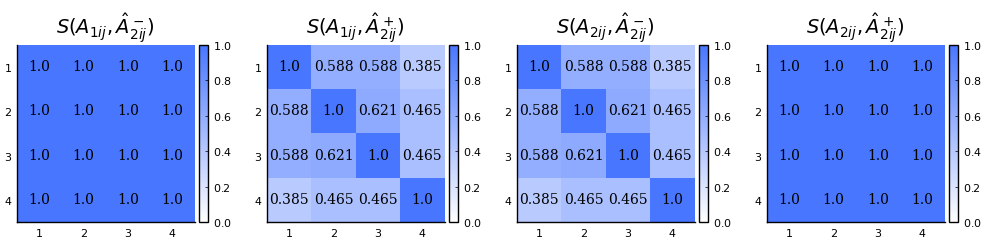

"非対角成分の算術平均: 1.0, 0.519, 0.519, 1.0"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.455, \\left[   2.0,   2.0 \\right], 2.494 \\right] & \\left[ 1.001, \\left[ 1.001, 1.067 \\right], 1.459 \\right] & \\left[ 1.333, \\left[ 1.333, 1.333 \\right], 1.523 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.521 \\right] \\\\ \\left[ 0.657, \\left[  0.75,  0.75 \\right],  0.75 \\right] & \\left[ 0.955, \\left[   1.5,   1.5 \\right], 1.713 \\right] & \\left[ 0.658, \\left[ 0.751,   0.8 \\right],   1.0 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

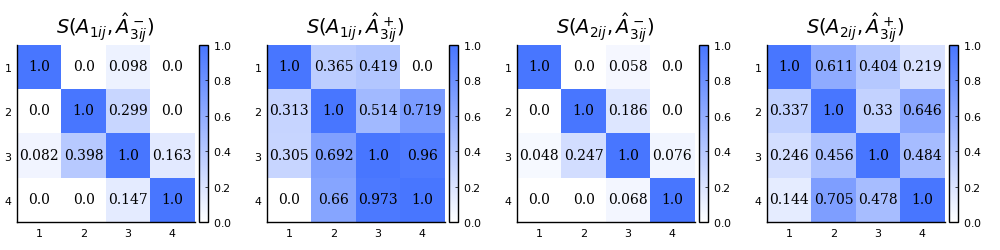

"非対角成分の算術平均: 0.099, 0.493, 0.057, 0.422"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.8, \\emptyset,   2.5 \\right] & \\left[ 0.533, \\emptyset, 1.667 \\right] & \\left[   0.8, \\emptyset, 1.667 \\right] \\\\ \\left[   0.4, \\emptyset,  1.25 \\right] & \\left[   1.0, \\l" ⋯ 269 bytes ⋯ "  1.0 \\right] & \\left[   0.8, \\emptyset, 1.875 \\right] \\\\ \\left[   0.6, \\emptyset,  1.25 \\right] & \\left[   0.8, \\left[   1.5,   1.5 \\right], 1.875 \\right] & \\left[ 0.533, \\emptyset,  1.25 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

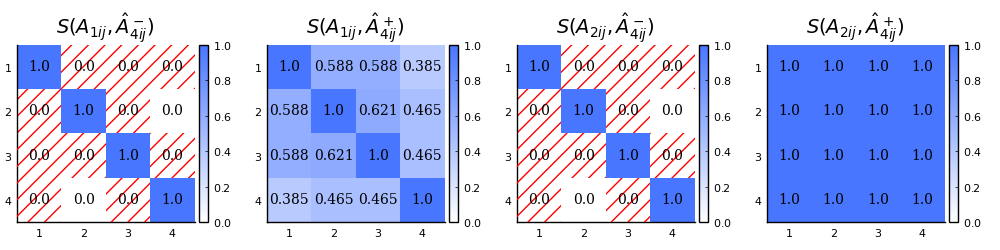

"非対角成分の算術平均: 0.0, 0.519, 0.0, 1.0"

In [9]:
A₁ = [
    1..1 1..2 (2/3)..(4/3) 1..(4/3)
    (1/2)..1 1..1 (4/9)..1 (2/3)..1
    (3/4)..(3/2) 1..(9/4) 1..1 1..(3/2)
    (3/4)..1 1..(3/2) (2/3)..1 1..1
]
_, n = size(A₁)
A₂ = fill(1..1, (n, n))
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 4 / 5)..(A₁[i,j].hi * 5 / 4)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

<!-- ともに弱い整合性を持ち， $A_{1ij} \subseteq A_{2ij}$

```
A₁ = [
    1..1 2..5 2..4 2..3
    (1/5)..(1/2) 1..1 (1/5)..4 (1/5)..3
    (1/4)..(1/2) (1/4)..5 1..1 (1/4)..3
    (1/3)..(1/2) (1/3)..5 (1/3)..4 1..1
]
A₂ = fill(1..1, size(A₁))
_, n = size(A₁)
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 1/1.1)..(A₁[i,j].hi * 1.1)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)
``` -->

推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列　2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 0.03]$ の一様分布に従う乱数の分だけ上下に幅をもたせている

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.981, 2.033 \right] & \left[ 3.974, 4.109 \right] & \left[ 3.958, 4.048 \right] \\ \left[ 0.492, 0.505 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.944, 2.048 \right] & \left[ 1.971, 2.045 \right] \\ \left[ 0.243, 0.252 \right] & \left[ 0.488, 0.515 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.983, 1.022 \right] \\ \left[ 0.247, 0.253 \right] & \left[ 0.489, 0.507 \right] & \left[ 0.978, 1.017 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.998, 2.01 \right] & \left[ 3.974, 4.05 \right] & \left[ 3.962, 4.041 \right] \\ \left[ 0.497, 0.5 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.945, 2.015 \right] & \left[ 1.942, 2.033 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.496, 0.514 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.972, 1.021 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.492, 0.515 \right] & \left[ 0.979, 1.029 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998, 1.998 \\right], 2.043 \\right] & \\left[ 3.911, \\emptyset, 4.109 \\right] & \\left[ 3.958, \\left[ 3.962, 3.962 \\right], 4.061 \\right] \\\\ \\left[  0.49, \\left[ " ⋯ 413 bytes ⋯ "ht], 1.035 \\right] \\\\ \\left[ 0.246, \\left[ 0.252, 0.252 \\right], 0.253 \\right] & \\left[ 0.489, \\left[ 0.504, 0.504 \\right], 0.516 \\right] & \\left[ 0.966, \\left[ 1.003, 1.003 \\right], 1.029 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

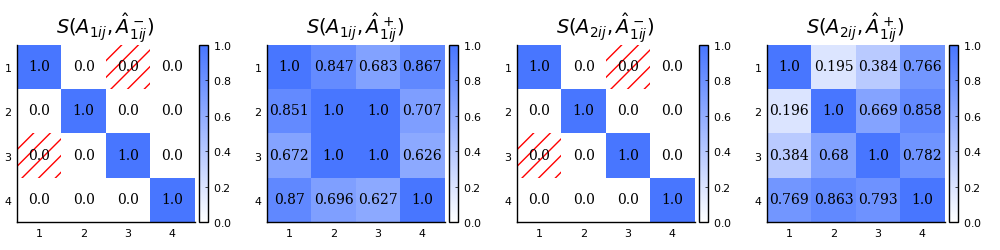

"非対角成分の算術平均: 0.0, 0.787, 0.0, 0.612"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.977, \\left[   2.0,  2.01 \\right], 2.033 \\right] & \\left[ 3.948, \\left[ 3.974, 4.031 \\right], 4.109 \\right] & \\left[ 3.944, \\left[ 3.962, 4.041 \\right], 4.048 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.024 \\right] \\\\ \\left[ 0.247, \\left[ 0.247, 0.252 \\right], 0.254 \\right] & \\left[ 0.489, \\left[ 0.495, 0.507 \\right], 0.515 \\right] & \\left[ 0.976, \\left[ 0.983, 1.017 \\right], 1.041 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

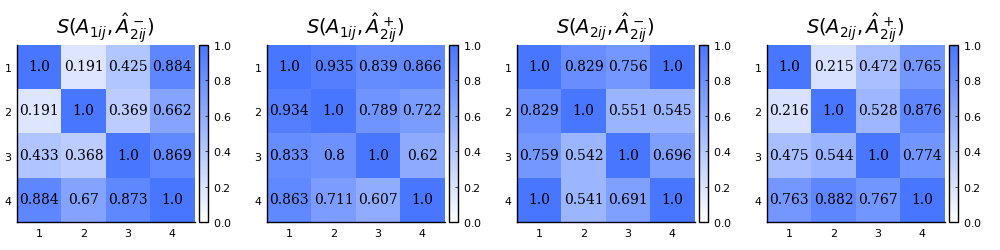

"非対角成分の算術平均: 0.568, 0.793, 0.728, 0.606"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.998, \\left[ 2.008, 2.009 \\right], 2.028 \\right] & \\left[ 3.952, \\left[ 3.972, 3.976 \\right], 4.051 \\right] & \\left[ 3.958, \\left[ 4.041, 4.048 \\right], 4.053 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.025 \\right] \\\\ \\left[ 0.247, \\left[ 0.247, 0.247 \\right], 0.253 \\right] & \\left[ 0.493, \\left[ 0.496, 0.502 \\right], 0.512 \\right] & \\left[ 0.976, \\left[ 0.981, 0.999 \\right], 1.023 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

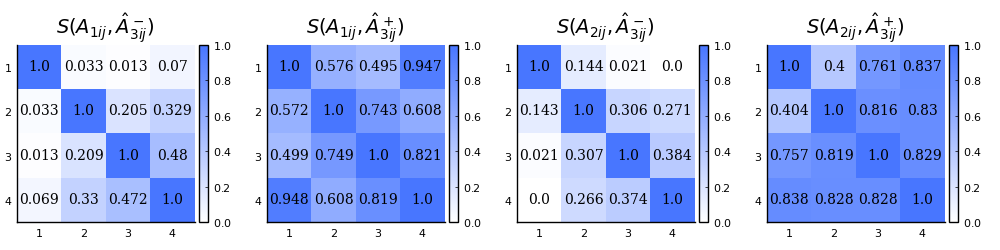

"非対角成分の算術平均: 0.188, 0.699, 0.186, 0.746"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\emptyset, 2.033 \\right] & \\left[ 3.944, \\emptyset, 4.109 \\right] & \\left[ 3.937, \\emptyset, 4.061 \\right] \\\\ \\left[ 0.492, \\emptyset, 0.505 \\right] & \\left[   1.0, \\l" ⋯ 233 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 0.963, \\emptyset,  1.03 \\right] \\\\ \\left[ 0.246, \\emptyset, 0.254 \\right] & \\left[ 0.489, \\emptyset, 0.515 \\right] & \\left[ 0.971, \\emptyset, 1.038 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

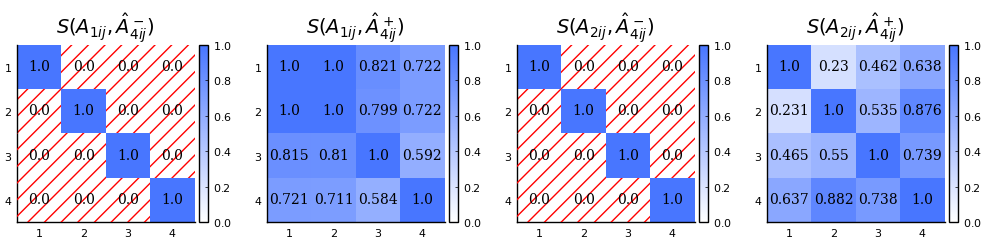

"非対角成分の算術平均: 0.0, 0.775, 0.0, 0.582"

In [10]:
A = [
    1 2 4 4
    1/2 1 2 2
    1/4 1/2 1 1
    1/4 1/2 1 1
]

A₁ = randamizedIntervalPCM(A, 1234, 3e-2)
A₂ = randamizedIntervalPCM(A, 134, 3e-2)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列 2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 0.3]$ の一様分布に従う乱数の分だけ上下に幅をもたせている

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.564, 2.231 \right] & \left[ 3.102, 4.959 \right] & \left[ 3.625, 4.692 \right] \\ \left[ 0.448, 0.639 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.523, 2.056 \right] & \left[ 1.901, 2.608 \right] \\ \left[ 0.202, 0.322 \right] & \left[ 0.486, 0.657 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.975, 1.144 \right] \\ \left[ 0.213, 0.276 \right] & \left[ 0.383, 0.526 \right] & \left[ 0.874, 1.026 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.814, 2.358 \right] & \left[ 3.746, 5.231 \right] & \left[ 3.598, 4.502 \right] \\ \left[ 0.424, 0.551 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.503, 2.539 \right] & \left[ 1.724, 2.503 \right] \\ \left[ 0.191, 0.267 \right] & \left[ 0.394, 0.666 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.841, 1.244 \right] \\ \left[ 0.222, 0.278 \right] & \left[ 0.399, 0.58 \right] & \left[ 0.804, 1.189 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.564, \\left[ 1.814, 1.814 \\right], 2.358 \\right] & \\left[ 3.102, \\emptyset, 5.231 \\right] & \\left[ 3.598, \\left[ 3.625, 3.625 \\right], 4.692 \\right] \\\\ \\left[ 0.424, \\left[ " ⋯ 413 bytes ⋯ "ht], 1.337 \\right] \\\\ \\left[ 0.213, \\left[ 0.276, 0.276 \\right], 0.278 \\right] & \\left[ 0.383, \\left[   0.5,   0.5 \\right], 0.615 \\right] & \\left[ 0.748, \\left[ 0.937, 0.937 \\right], 1.368 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

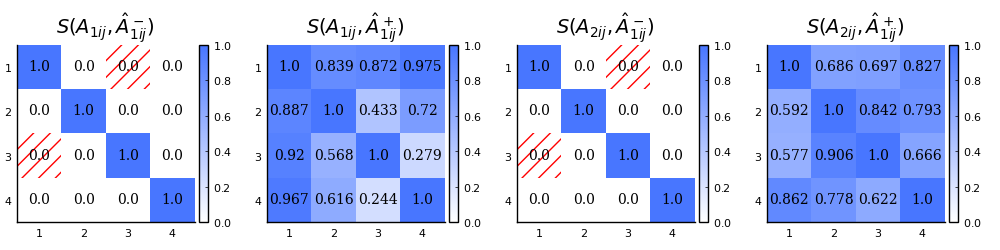

"非対角成分の算術平均: 0.0, 0.693, 0.0, 0.737"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.564, \\left[ 1.822, 2.231 \\right], 2.358 \\right] & \\left[ 3.102, \\left[ 3.746, 4.045 \\right], 5.231 \\right] & \\left[ 3.598, \\left[ 3.927, 4.502 \\right], 4.692 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.338 \\right] \\\\ \\left[ 0.213, \\left[ 0.222, 0.255 \\right], 0.278 \\right] & \\left[ 0.377, \\left[ 0.437, 0.526 \\right],  0.58 \\right] & \\left[ 0.747, \\left[ 0.898, 0.954 \\right], 1.286 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

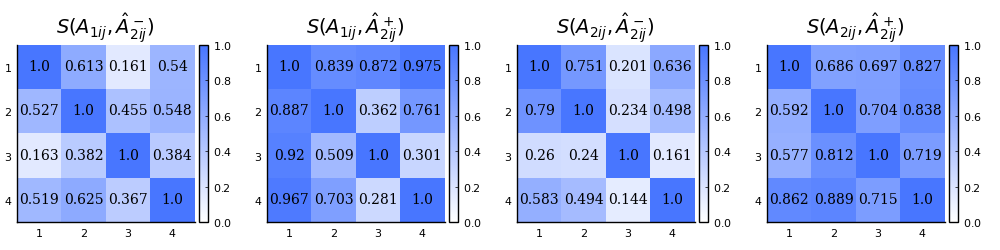

"非対角成分の算術平均: 0.44, 0.698, 0.416, 0.743"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 2.056, \\left[ 2.064, 2.208 \\right], 2.254 \\right] & \\left[ 3.659, \\left[ 3.674, 3.746 \\right], 3.785 \\right] & \\left[  3.97, \\left[ 4.202, 4.502 \\right], 4.588 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.236 \\right] \\\\ \\left[ 0.218, \\left[ 0.222, 0.238 \\right], 0.252 \\right] & \\left[ 0.455, \\left[ 0.457, 0.531 \\right], 0.556 \\right] & \\left[ 0.809, \\left[ 0.813, 0.891 \\right], 0.944 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

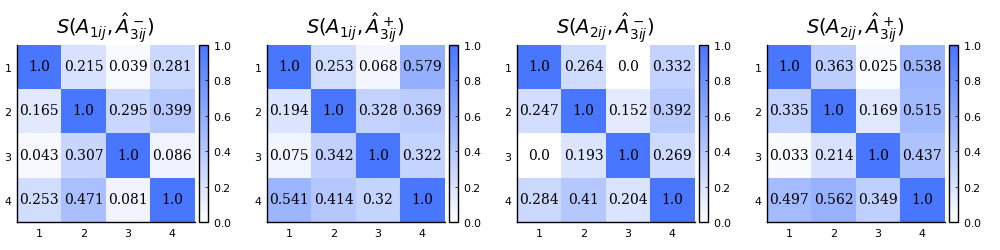

"非対角成分の算術平均: 0.22, 0.317, 0.229, 0.336"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.564, \\emptyset, 2.358 \\right] & \\left[ 3.102, \\emptyset, 5.231 \\right] & \\left[ 3.598, \\emptyset, 4.692 \\right] \\\\ \\left[ 0.424, \\emptyset, 0.639 \\right] & \\left[   1.0, \\l" ⋯ 233 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 0.688, \\emptyset, 1.381 \\right] \\\\ \\left[ 0.213, \\emptyset, 0.278 \\right] & \\left[ 0.365, \\emptyset, 0.655 \\right] & \\left[ 0.724, \\emptyset, 1.454 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

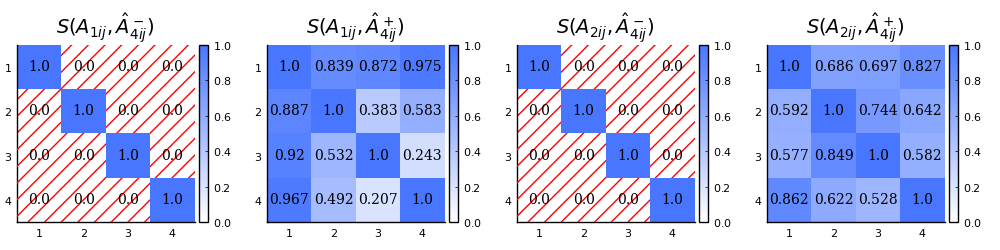

"非対角成分の算術平均: 0.0, 0.659, 0.0, 0.684"

In [11]:
A = [
    1 2 4 4
    1/2 1 2 2
    1/4 1/2 1 1
    1/4 1/2 1 1
]

A₁ = randamizedIntervalPCM(A, 14, 3e-1)
A₂ = randamizedIntervalPCM(A, 1234, 3e-1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

完全整合はしていない PCM にランダムに幅をもたせる

In [12]:
using LinearAlgebra

A = [
    1 2 3 10
    1/2 1 3 8
    1/3 1/3 1 3
    1/10 1/8 1/3 1
]

_, n = size(A)

λ = maximum(real.(filter(e -> imag(e) == 0,eigvals(A))))
(λ - n) / (n - 1)

0.015252586019425252

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 5.909, 9.73 \right] & \left[ 2.334, 3.893 \right] & \left[ 8.353, 12.974 \right] \\ \left[ 0.103, 0.169 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.954, 4.065 \right] & \left[ 6.654, 8.351 \right] \\ \left[ 0.257, 0.428 \right] & \left[ 0.246, 0.338 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.263, 3.309 \right] \\ \left[ 0.077, 0.12 \right] & \left[ 0.12, 0.15 \right] & \left[ 0.302, 0.442 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 5.932, 11.09 \right] & \left[ 2.367, 3.578 \right] & \left[ 8.663, 11.158 \right] \\ \left[ 0.09, 0.169 \right] & \left[ 1.0, 1.0 \right] & \left[ 3.714, 5.113 \right] & \left[ 6.615, 10.334 \right] \\ \left[ 0.279, 0.422 \right] & \left[ 0.196, 0.269 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.648, 4.048 \right] \\ \left[ 0.09, 0.115 \right] & \left[ 0.097, 0.151 \right] & \left[ 0.247, 0.378 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 0.958, \\emptyset, 11.09 \\right] & \\left[ 2.334, \\emptyset, 24.019 \\right] & \\left[ 5.462, \\left[ 8.983, 8.983 \\right], 49.344 \\right] \\\\ \\left[  0.09, \\emptyset, 1.044 \\right" ⋯ 273 bytes ⋯ " 1.0 \\right] & \\left[ 0.374, \\emptyset, 12.676 \\right] \\\\ \\left[  0.02, \\left[ 0.111, 0.111 \\right], 0.183 \\right] & \\left[ 0.089, \\emptyset, 1.083 \\right] & \\left[ 0.079, \\emptyset, 2.674 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

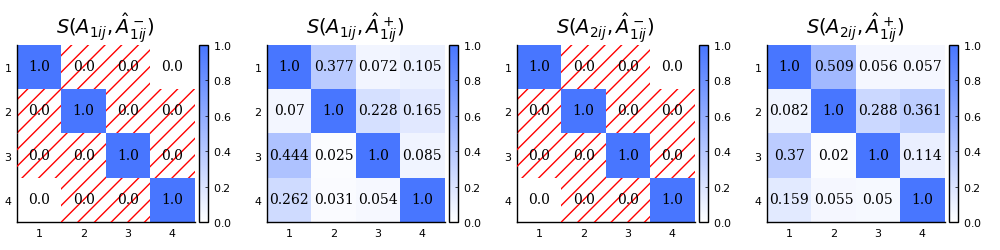

"非対角成分の算術平均: 0.0, 0.16, 0.0, 0.177"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 2.926, \\left[ 5.932, 5.932 \\right], 11.09 \\right] & \\left[ 2.334, \\left[ 3.893, 3.893 \\right], 15.346 \\right] & \\left[ 8.353, \\left[ 11.158, 11.158 \\right], 31.015 \\right] \\\\" ⋯ 455 bytes ⋯ "t], 12.956 \\right] \\\\ \\left[ 0.032, \\left[  0.09,  0.09 \\right],  0.12 \\right] & \\left[ 0.097, \\left[ 0.532, 0.532 \\right], 1.294 \\right] & \\left[ 0.077, \\left[ 0.349, 0.349 \\right], 1.791 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

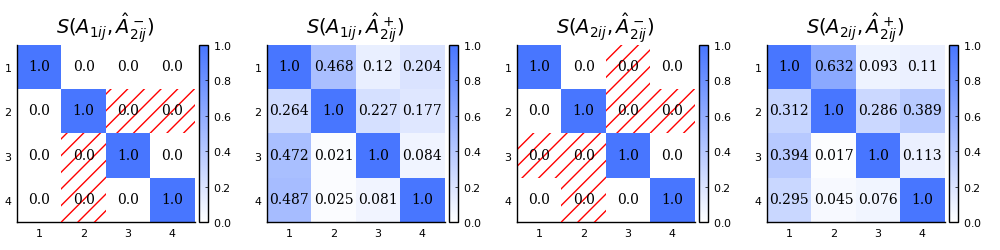

"非対角成分の算術平均: 0.0, 0.219, 0.0, 0.23"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 2.737, \\left[ 5.866,  9.73 \\right],  9.73 \\right] & \\left[ 2.334, \\emptyset, 11.125 \\right] & \\left[ 8.513, \\left[ 8.814, 22.854 \\right], 22.854 \\right] \\\\ \\left[ 0.103, \\lef" ⋯ 416 bytes ⋯ "ht], 9.793 \\right] \\\\ \\left[ 0.044, \\left[ 0.044, 0.113 \\right], 0.117 \\right] & \\left[  0.12, \\left[ 0.248, 1.143 \\right], 1.143 \\right] & \\left[ 0.102, \\left[ 0.123, 0.331 \\right], 1.307 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

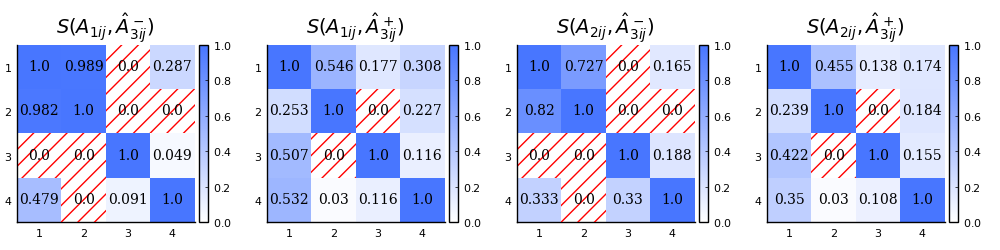

"非対角成分の算術平均: 0.24, 0.234, 0.214, 0.188"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 2.737, \\emptyset, 11.09 \\right] & \\left[ 2.334, \\emptyset, 14.144 \\right] & \\left[ 8.353, \\emptyset, 28.586 \\right] \\\\ \\left[  0.09, \\emptyset, 0.365 \\right] & \\left[   1.0, " ⋯ 237 bytes ⋯ ",   1.0 \\right],   1.0 \\right] & \\left[ 0.613, \\emptyset, 12.077 \\right] \\\\ \\left[ 0.035, \\emptyset,  0.12 \\right] & \\left[ 0.097, \\emptyset,  1.28 \\right] & \\left[ 0.083, \\emptyset, 1.633 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

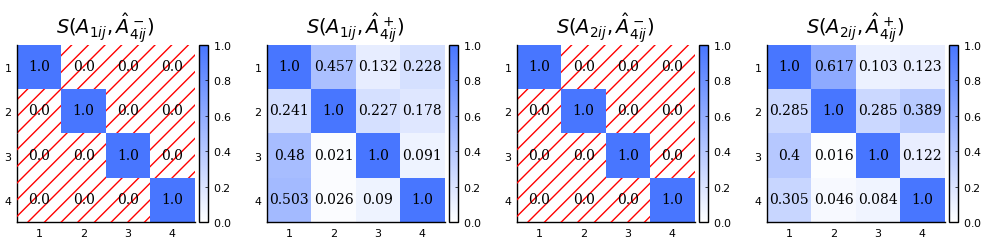

"非対角成分の算術平均: 0.0, 0.223, 0.0, 0.231"

┌ Warning: Invalid input, empty interval is returned
└ @ IntervalArithmetic /opt/julia/packages/IntervalArithmetic/BORQB/src/intervals/intervals.jl:141
┌ Warning: Invalid input, empty interval is returned
└ @ IntervalArithmetic /opt/julia/packages/IntervalArithmetic/BORQB/src/intervals/intervals.jl:141
┌ Warning: Invalid input, empty interval is returned
└ @ IntervalArithmetic /opt/julia/packages/IntervalArithmetic/BORQB/src/intervals/intervals.jl:141
┌ Warning: Invalid input, empty interval is returned
└ @ IntervalArithmetic /opt/julia/packages/IntervalArithmetic/BORQB/src/intervals/intervals.jl:141
┌ Warning: Invalid input, empty interval is returned
└ @ IntervalArithmetic /opt/julia/packages/IntervalArithmetic/BORQB/src/intervals/intervals.jl:141
┌ Warning: Invalid input, empty interval is returned
└ @ IntervalArithmetic /opt/julia/packages/IntervalArithmetic/BORQB/src/intervals/intervals.jl:141
┌ Warning: Invalid input, empty interval is returned
└ @ IntervalArithmetic /opt/julia/p

In [13]:
A = [
    1 8 3 10
    1/8 1 4 8
    1/3 1/4 1 3
    1/10 1/8 1/3 1
]

A₁ = randamizedIntervalPCM(A, 124, 3.5e-1)
A₂ = randamizedIntervalPCM(A, 4, 3.5e-1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

<!-- - 2 つとも整合していない
- 幅 $0.1$ の一様分布に従う乱数をもとに自然対数スケールで幅を持たせる
- $6 \times 6$

手法 3 の挙動がおかしい

```
A = [
    1 6 5 4 8 8
    1/6 1 2 2 6 4
    1/5 1/2 1 2 7 3
    1/4 1/2 1/2 1 6 5
    1/8 1/6 1/7 1/6 1 2
    1/8 1/4 1/3 1/5 1/2 1
]

A₁ = randamizedIntervalPCM(A, 234, 0.1)
A₂ = randamizedIntervalPCM(A, 134, 0.1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isWeaklyConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂, (1600, 400))
``` -->

幅をつける際に用いる一様分布の幅をパラメータにしてシミュレーションする，ということを考えられる．今後の課題．

重みつけたら挙動変わる？

## **conflict resolution の図で点が見づらい**
## **元の PCM が完全整合ではない場合の例が一つ欲しい**
## **非対角成分の算術平均を取った後に， DM で算術平均を取る → 内外それぞれ順番付けができる**

todo
- conflict resolution 見やすくする
- 元が完全整合ではない例
- 手法の順位付けの整理
- SCIS 概要送る
- 卒論概要

なぜ ill-known ?  
→ この範囲については考慮すべきというのを考える．  
重要度に色々なとり方があり，正規性などがあるために基準/代替案どうしが干渉する  
→ なので区間の集合で考える